In [45]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy import ndimage

import numpy as np
import os
import json

import random
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
def read_nifti_file(file_path):
    """Read and load volume"""
    # Read file
    img = sitk.ReadImage(file_path)
    # 轉為 NumPy 陣列
    img_arr = sitk.GetArrayFromImage(img)

    return img_arr

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    # Get current depth
    current_width = img.shape[0]
    current_height = img.shape[1]
    current_depth = img.shape[-1]
    
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def preprocess_img(file_path):
    img = read_nifti_file(file_path)
    return resize_volume(img)

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap="gray", origin="lower")

In [52]:
data_dir = 'C:\\Users\\Gina\\Lab\\kidney\\nnUNet-1\\Result'
mask_path = os.path.join(data_dir, 'case_00001.nii.gz')

data = read_nifti_file(mask_path)
resize_data = resize_volume(data)

In [53]:
print('original image (black):', len(np.where(data == 0)[0]))
print('original image (kidney):', len(np.where(data == 1)[-1]))
print('original image (tumor):', np.where(data == 2))
print('-' * 20)
print('resize image (black):', len(np.where(resize_data == 0)[0]))
print('resize image (kidney):', len(np.where(resize_data == 1)[-1]))
print('resize image (tumor):', len(np.where(resize_data == 2)))

original image (black): 156347323
original image (kidney): 1446043
original image (tumor): (array([100, 100, 101, ..., 147, 147, 147], dtype=int64), array([297, 297, 294, ..., 273, 273, 273], dtype=int64), array([339, 340, 338, ..., 263, 264, 265], dtype=int64))
--------------------
resize image (black): 1039098
resize image (kidney): 9369
resize image (tumor): 3


In [80]:
def get_bounding_box(img):
    tumor_region = np.where(img == 2)

    if len(tumor_region[0]) == 0:
        return img

    l_width = min(tumor_region[0])
    l_height = min(tumor_region[1])
    l_depth = min(tumor_region[2])

    r_width = max(tumor_region[0])
    r_height = max(tumor_region[1])
    r_depth = max(tumor_region[2])

    # turn the kidney part to black
    img[np.where(img == 1)] = 0

    return img[l_width:r_width, l_height:r_height, l_depth:r_depth]

def get_tumor_region(file_path):
    img = read_nifti_file(file_path)
    return get_bounding_box(img)


(array([100, 100, 101, ..., 147, 147, 147], dtype=int64), array([297, 297, 294, ..., 273, 273, 273], dtype=int64), array([339, 340, 338, ..., 263, 264, 265], dtype=int64))
image (tumor): (array([ 0,  0,  1, ..., 46, 46, 46], dtype=int64), array([43, 43, 40, ..., 21, 21, 21], dtype=int64), array([85, 86, 84, ..., 10, 11, 12], dtype=int64))


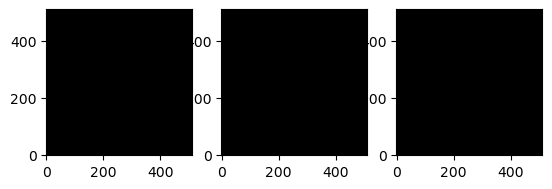

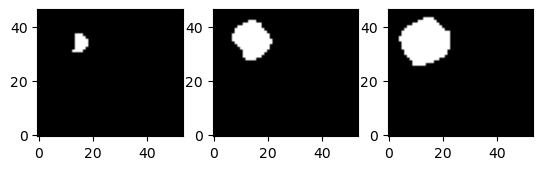

In [70]:
# 顯示各軸切面
b_img = get_bounding_box(data)
print('image (tumor):', np.where(b_img == 2))

show_slices([data[:, :, 187], data[:, :, 188], data[:, :, 189]])
show_slices([b_img[:, :, 0], b_img[:, :, 1], b_img[:, :, 2]])
# show_slices([resize_data[:, :, 29], resize_data[:, :, 30], resize_data[:, :, 48]])

In [6]:
# import label data
with open('C:\\Users\\Gina\\Lab\\kidney\\kits21\\kits21\\data\\kits.json') as f:
    data = json.load(f)

label = [ case['tumor_histologic_subtype'] for case in data ]

In [7]:
useless_type = ['rcc_unclassified',
                'urothelial',
                'mest',
                'collecting_duct_undefined',
                'oncocytoma',
                'clear_cell_papillary_rcc', 
                'multilocular_cystic_rcc', 
                'other', 'wilms', 
                'angiomyolipoma', 'spindle_cell_neoplasm']

drop_idx_img = []
for idx, value in enumerate(label):
    if value in useless_type:
        drop_idx_img.append(idx)

print('Useless img:', drop_idx_img)

Useless img: [17, 18, 19, 20, 31, 42, 43, 56, 77, 82, 88, 90, 92, 104, 106, 116, 120, 133, 137, 155, 156, 176, 183, 188, 200, 202, 205, 211, 225, 228, 234, 237, 238, 249, 253, 258, 275, 277, 279, 288, 291]


In [74]:
#  input mask
data_dir = 'C:\\Users\\Gina\\Lab\\kidney\\nnUNet-1\\Result'
mask_path = []

for file in os.listdir(data_dir):
    if "nii.gz" in file:
        if int(file[5:10]) not in drop_idx_img:
            mask_path.append(os.path.join(data_dir, file))


In [81]:
mask = np.array([
    get_tumor_region(path) for path in mask_path
    ])
label = np.array(label)

C:\Users\Gina\AppData\Local\Temp\ipykernel_21364\3453872739.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mask = np.array([


In [10]:
label = np.delete(label, drop_idx_img)

In [12]:
import pandas as pd

label_dummy = pd.get_dummies(label)

In [13]:
label_dummy

,chromophobe,clear_cell_rcc,papillary
0,0,1,0
1,0,0,1
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
254,0,1,0
255,0,1,0
256,0,1,0
257,0,1,0


In [20]:
from sklearn.model_selection  import train_test_split

x_train, x_val, y_train, y_val = train_test_split(mask, label_dummy, test_size = 0.2)

print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 207 and 52.


In [21]:
y_train

,chromophobe,clear_cell_rcc,papillary
4,0,1,0
32,0,1,0
196,0,1,0
14,0,1,0
49,0,1,0
...,...,...,...
118,0,1,0
176,0,1,0
209,0,1,0
174,0,1,0


In [22]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0.0
        volume[volume > 1] = 1.0
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    # volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    # print(volume.get_shape())
    label = tf.cast(label, tf.float32)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    label = tf.cast(label, tf.float32)
    return volume, label


In [23]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train.to_numpy()))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val.to_numpy()))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [24]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=3, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 14, 64)    256   

In [25]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


Epoch 1/100
104/104 - 12s - loss: 0.5103 - acc: 0.7633 - val_loss: 0.3712 - val_acc: 0.8269
Epoch 2/100
104/104 - 7s - loss: 0.4752 - acc: 0.7778 - val_loss: 0.3819 - val_acc: 0.8269
Epoch 3/100
104/104 - 7s - loss: 0.4926 - acc: 0.7778 - val_loss: 0.3741 - val_acc: 0.8269
Epoch 4/100
104/104 - 6s - loss: 0.4408 - acc: 0.7778 - val_loss: 0.3908 - val_acc: 0.8269
Epoch 5/100
104/104 - 7s - loss: 0.4407 - acc: 0.7778 - val_loss: 0.3903 - val_acc: 0.8269
Epoch 6/100
104/104 - 6s - loss: 0.4226 - acc: 0.7778 - val_loss: 0.3997 - val_acc: 0.8269
Epoch 7/100
104/104 - 6s - loss: 0.4400 - acc: 0.7778 - val_loss: 0.3924 - val_acc: 0.8269
Epoch 8/100
104/104 - 6s - loss: 0.4283 - acc: 0.7778 - val_loss: 0.3774 - val_acc: 0.8269
Epoch 9/100
104/104 - 7s - loss: 0.4325 - acc: 0.7778 - val_loss: 0.3820 - val_acc: 0.8269
Epoch 10/100
104/104 - 7s - loss: 0.4280 - acc: 0.7778 - val_loss: 0.3838 - val_acc: 0.8269
Epoch 11/100
104/104 - 7s - loss: 0.4115 - acc: 0.7778 - val_loss: 0.3958 - val_acc: 0.8

In [30]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 3))
# ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    print(i, '. train:', model.history.history[metric])
    print(i, '. val:', model.history.history["val_" + metric])
    # ax[i].plot(model.history.history[metric])
    # ax[i].plot(model.history.history["val_" + metric])
    # ax[i].set_title("Model {}".format(metric))
    # ax[i].set_xlabel("epochs")
    # ax[i].set_ylabel(metric)
    # ax[i].legend(["train", "val"])


0 . train: [0.7632850408554077, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544]
0 . val: [0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042, 0.8269230723381042]
1 . train: [0.5102962851524353, 0.4751507341861725, 0.4926392138004303, 0.44076257944107056, 0.44069966673851013, 0.42261409759521484, 0.43998831510543823, 0.42833635210990906, 0.4325442910194397, 0.4280364215373993, 0.41146647930145264, 0.39679163694381714, 0.41983562707901, 0.41670456528663635, 0.4063231647014618, 0.3850000500679016]


In [33]:
np.argmax(model.predict(train_dataset), axis=1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [34]:
def get_model_2(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=3, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model2 = get_model_2(width=128, height=128, depth=64)
model2.summary()


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 61, 61, 29, 128)   221312    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 30, 30, 14, 128)   0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 14, 128)   512   

In [38]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc", tf.keras.metrics.AUC()],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification_2.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
104/104 - 8s - loss: 1.0117 - acc: 0.7391 - auc: 0.8171 - val_loss: 0.9484 - val_acc: 0.8269 - val_auc: 0.8889
Epoch 2/100
104/104 - 7s - loss: 0.9038 - acc: 0.7778 - auc: 0.8262 - val_loss: 0.8526 - val_acc: 0.8269 - val_auc: 0.8614
Epoch 3/100
104/104 - 7s - loss: 0.8582 - acc: 0.7778 - auc: 0.8262 - val_loss: 0.6793 - val_acc: 0.8269 - val_auc: 0.8475
Epoch 4/100
104/104 - 7s - loss: 0.7884 - acc: 0.7778 - auc: 0.8355 - val_loss: 0.6102 - val_acc: 0.8269 - val_auc: 0.8413
Epoch 5/100
104/104 - 7s - loss: 0.7810 - acc: 0.7778 - auc: 0.8262 - val_loss: 0.6398 - val_acc: 0.8269 - val_auc: 0.8466
Epoch 6/100
104/104 - 7s - loss: 0.7367 - acc: 0.7778 - auc: 0.8428 - val_loss: 0.6476 - val_acc: 0.8269 - val_auc: 0.8476
Epoch 7/100
104/104 - 7s - loss: 0.7394 - acc: 0.7778 - auc: 0.8270 - val_loss: 0.6708 - val_acc: 0.8269 - val_auc: 0.8744
Epoch 8/100
104/104 - 7s - loss: 0.7184 - acc: 0.7778 - auc: 0.8290 - val_loss: 0.5921 - val_acc: 0.8269 - val_auc: 0.8944
Epoch 9/100
104/

## 09/08
* 可以改成分 Low grade, High grade，應該比較好分
* 先把tumor這塊切出來，Cube 包起 tumor，只用這 cube，找最小的bounding box，再拉出來看